In [1]:
Nfft=1024;  #Number of frequency bands
P=4;        #PFF taps

import numpy as np
Nf2=Nfft//2;

#Load polyphase filter coefficients
W=np.load("coef4_%i_%i.npy" % (Nfft,P)).reshape([P,Nfft])
WI=W[::-1,:]

#Functions to calculate PFF and inverse PFF
def fftw(A,W,P):
  Nfft=A.shape[-1]
  Dx=A[:-P,:]*W[0]
  for i in range(1,P): Dx+=A[i:-P+i,:]*W[i]
  return np.fft.fft(Dx,axis=1)

def ifftw(A1,W,P):
  A=np.fft.ifft(A1,axis=1)
  Nfft=A.shape[-1]
  Dx=A[:-P,:]*W[0]
  for i in range(1,P): Dx+=A[i:-P+i,:]*W[i]
  return Dx

#some helper functions
def linroll(F,shift):
    n1,n2=F.shape
    return np.roll(F.reshape([n1*n2]),shift).reshape([n1,n2])
def m3(F): return F*F*F.conj()

#Calculate convolution of W, WI and x^2 
def Calcx2(S,W,WI):
    x=S[3:-5,:]
    N2,Nfft=S.shape;
    Wm=W.reshape([P,Nfft])
    WIm=WI.reshape([P,Nfft])
    x2=(x*x.conj()).reshape([N2-2*P,Nfft])
    Nf2=Nfft//2

    D2m=np.zeros([3,2*P,N2-3*P],dtype='complex')
    for ip in range(2*P):
        for i1 in range((0 if ip<P else ip-P+1),(P if ip>=P else ip+1)):
            i2=ip-i1
            D2m[0,ip]+=np.sum(Wm[i1]*WIm[i2]*x2[i1:-P+i1],axis=1);
            D2m[1,ip]+=np.sum(Wm[i1,:Nf2]*WIm[i2,Nf2:]*x2[i1:-P+i1,:Nf2],axis=1);
            D2m[2,ip]+=np.sum(Wm[i1,Nf2:]*WIm[i2,:Nf2]*x2[i1:-P+i1,Nf2:],axis=1);
    return D2m

#Calculate x^2 F(x)^-1 term 
def Applyx2(D2m,F4,F3):
    F3b=linroll(F3,Nfft)
    Dx2a=D2m[0,0,:,np.newaxis]*F4[:-2*P]
    Dx2b=D2m[2,0,:,np.newaxis]*F3[:-2*P]+D2m[1,0,:,np.newaxis]*F3b[:-2*P]     
    for ip in range(1,2*P):
        Dx2a+=D2m[0,ip,:,np.newaxis]*F4[ip:-2*P+ip]        
        Dx2b+=D2m[1,ip,:,np.newaxis]*F3b[ip:-2*P+ip]        
        Dx2b+=D2m[2,ip,:,np.newaxis]*F3[ip:-2*P+ip]        
    SF=1-2*(np.array(range(Nfft))%2)
    Dx2a+=Dx2b*SF;
    Dx2a*=-1/Nfft;      
    return Dx2a;

def cleanI3f(Ax,W,WI):  
    #Return the original and cleaned spectrum

    #MDFT
    F2=fftw(Ax,W,P)
    F3=fftw(linroll(Ax,-Nf2),W,P)  
    
    #Correction first term
    Dx0=fftw(m3(Ax[3:-5]),W,P) 
    #Correction second term
    D2m=Calcx2(Ax,W,WI)
    Dx2=Applyx2(D2m,F2,F3)  
    Fx=Dx0+Dx2; #3rd order spectrum
    PFx=np.mean(Fx*Fx.conj(),axis=0)

    #Original spectrum
    F2x=F2[3:-5]
    PF2=np.mean(F2x*F2x.conj(),axis=0)

    #Correlate 3rd order spectrum with original spectrum and substract
    C12=np.mean(F2x*Fx.conj(),axis=0)/PFx;
    Ck=C12*np.sqrt(PFx/PF2)
    return F2x,F2x-C12*Fx;


In [2]:
A1=np.load("CH0.npy")
A2=np.load("CH1.npy")
F1,F1y=cleanI3f(A1,W,WI)
F2,F2y=cleanI3f(A2,W,WI)


In [3]:
#Plot helper functions
import matplotlib.pyplot as plt
F0=150e6;
FS=100e6;
freq=np.arange(Nfft)/Nfft
freq-=1*(freq>=0.5)
freq=FS*freq+F0
freq2=np.roll(freq,Nf2)/1e6
def FFTpwr(F1):
    P1=np.mean(F1*F1.conj(),axis=0).real
    return np.roll(10*np.log10(P1),Nf2)
def FFTpwr2(F1,F2):
    P1=np.mean(F1*F2.conj(),axis=0)
    return np.roll(10*np.log10(np.abs(P1)),Nf2)
def corr(F1,F2):
    P1=np.mean(F1*F2.conj(),axis=0)/np.sqrt(np.mean(F1*F1.conj(),axis=0).real*np.mean(F2*F2.conj(),axis=0).real)
    return np.roll(P1,Nf2)

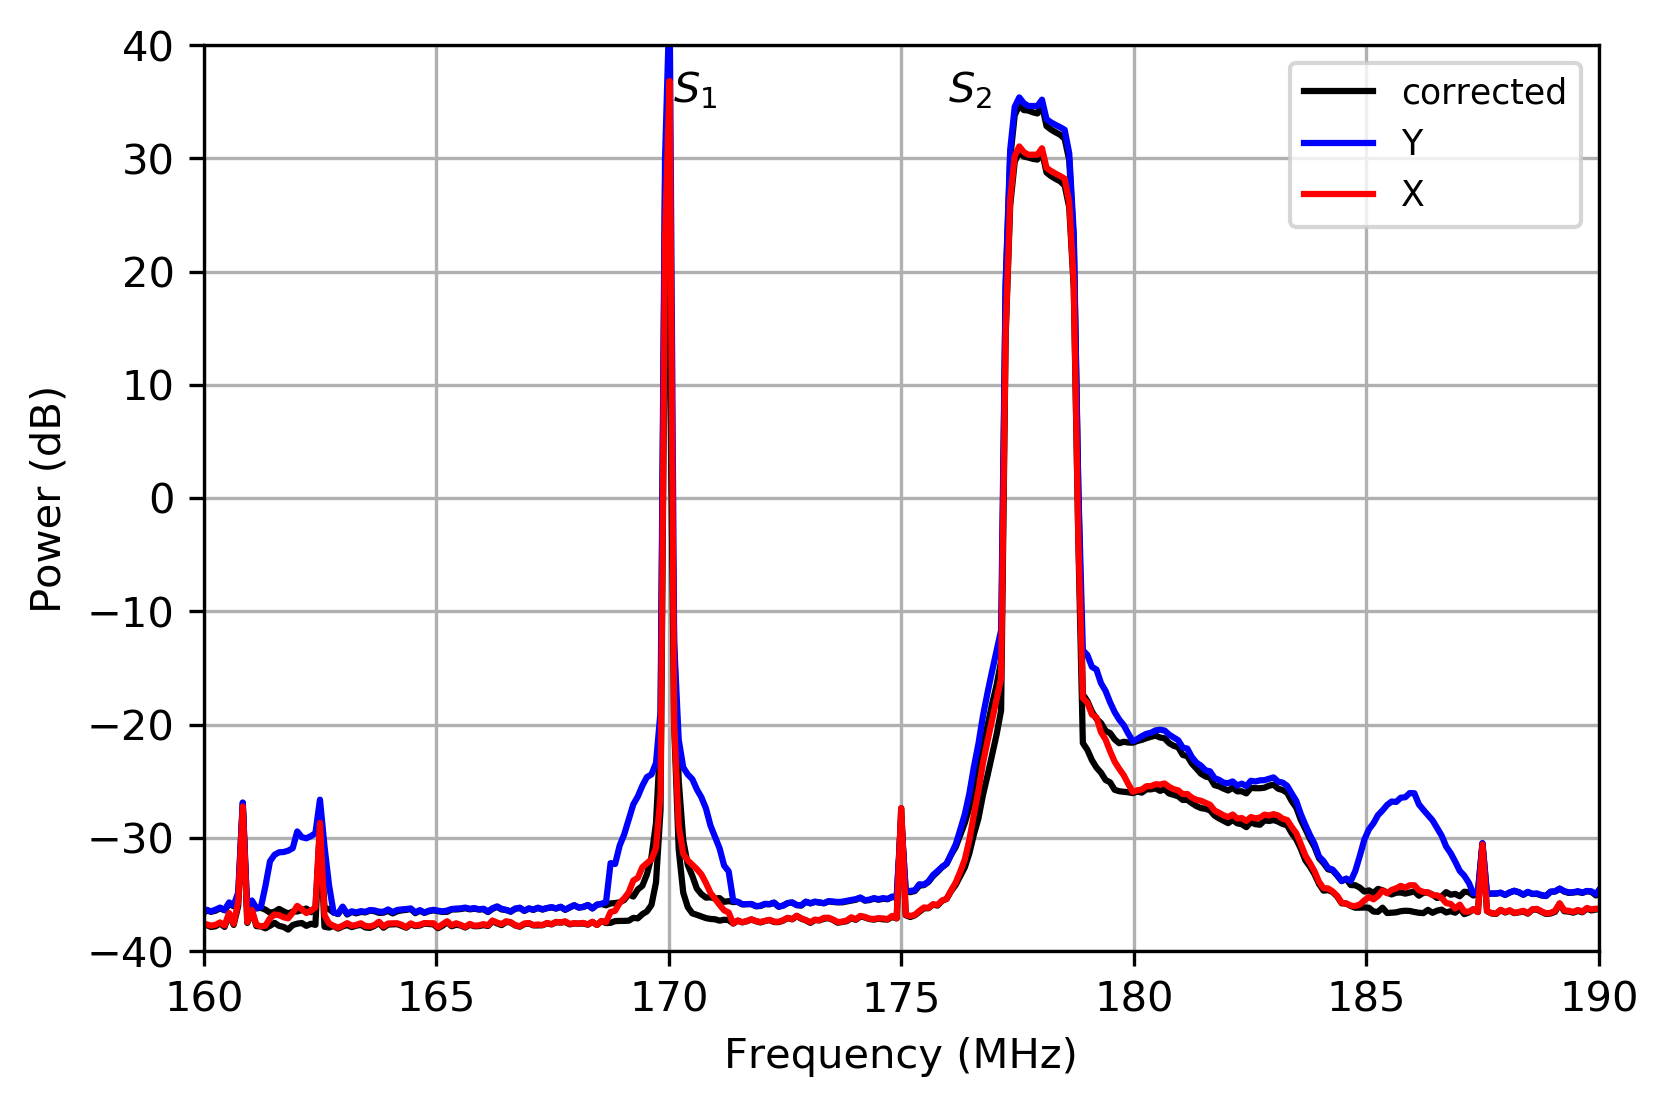

In [4]:
plt.figure(dpi=300)
plt.plot(freq2,FFTpwr(F1y),'k-',label='corrected')
plt.plot(freq2,FFTpwr(F2y),'k-')
plt.plot(freq2,FFTpwr(F2),'b-',label='Y')
plt.plot(freq2,FFTpwr(F1),'r-',label='X')
plt.legend(fontsize='small')
plt.xlim(160,190)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.ylim(-40,40)
plt.text(170.1,35,'$S_1$')
plt.text(176.0,35,'$S_2$')
plt.grid()
plt.savefig("XY2.png")

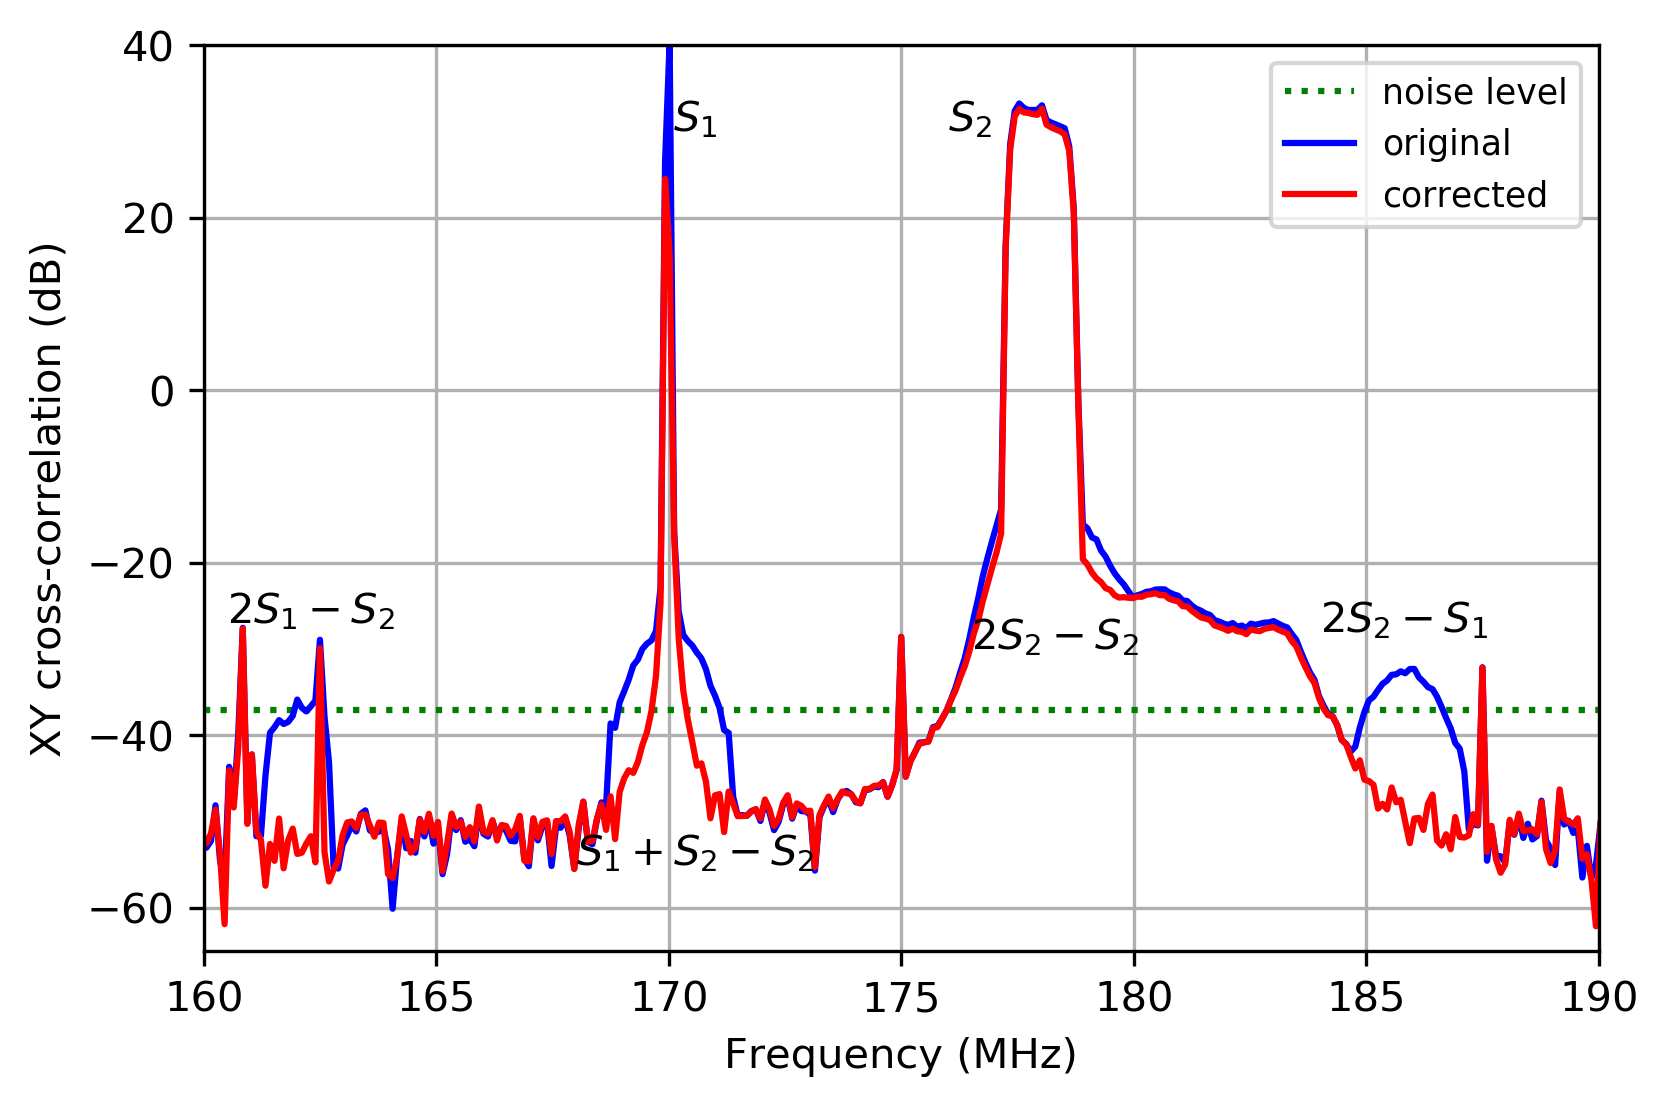

In [5]:
plt.figure(dpi=300)
plt.plot([160,190],[-37,-37],'g:',label='noise level')
plt.plot(freq2,FFTpwr2(F1[3:-5],F2[3:-5]),'b',label='original')
plt.plot(freq2,FFTpwr2(F1y,F2y),'r',label='corrected')
plt.legend(fontsize='small')
plt.xlim(160,190)
plt.xlabel("Frequency (MHz)")
plt.ylabel("XY cross-correlation (dB)")
plt.text(170.1,30,'$S_1$')
plt.text(176.0,30,'$S_2$')
plt.text(160.5,-27,'$2S_1-S_2$')
plt.text(168.0,-55,'$S_1+S_2-S_2$')
plt.text(176.5,-30,'$2S_2-S_2$')
plt.text(184.0,-28,'$2S_2-S_1$')
plt.ylim(-65,40)
plt.grid()
plt.savefig("XYcrosscorr2.png")

In [6]:
C=np.roll(corr(F1,F2),0)
Cy=np.roll(corr(F1y,F2y),0)

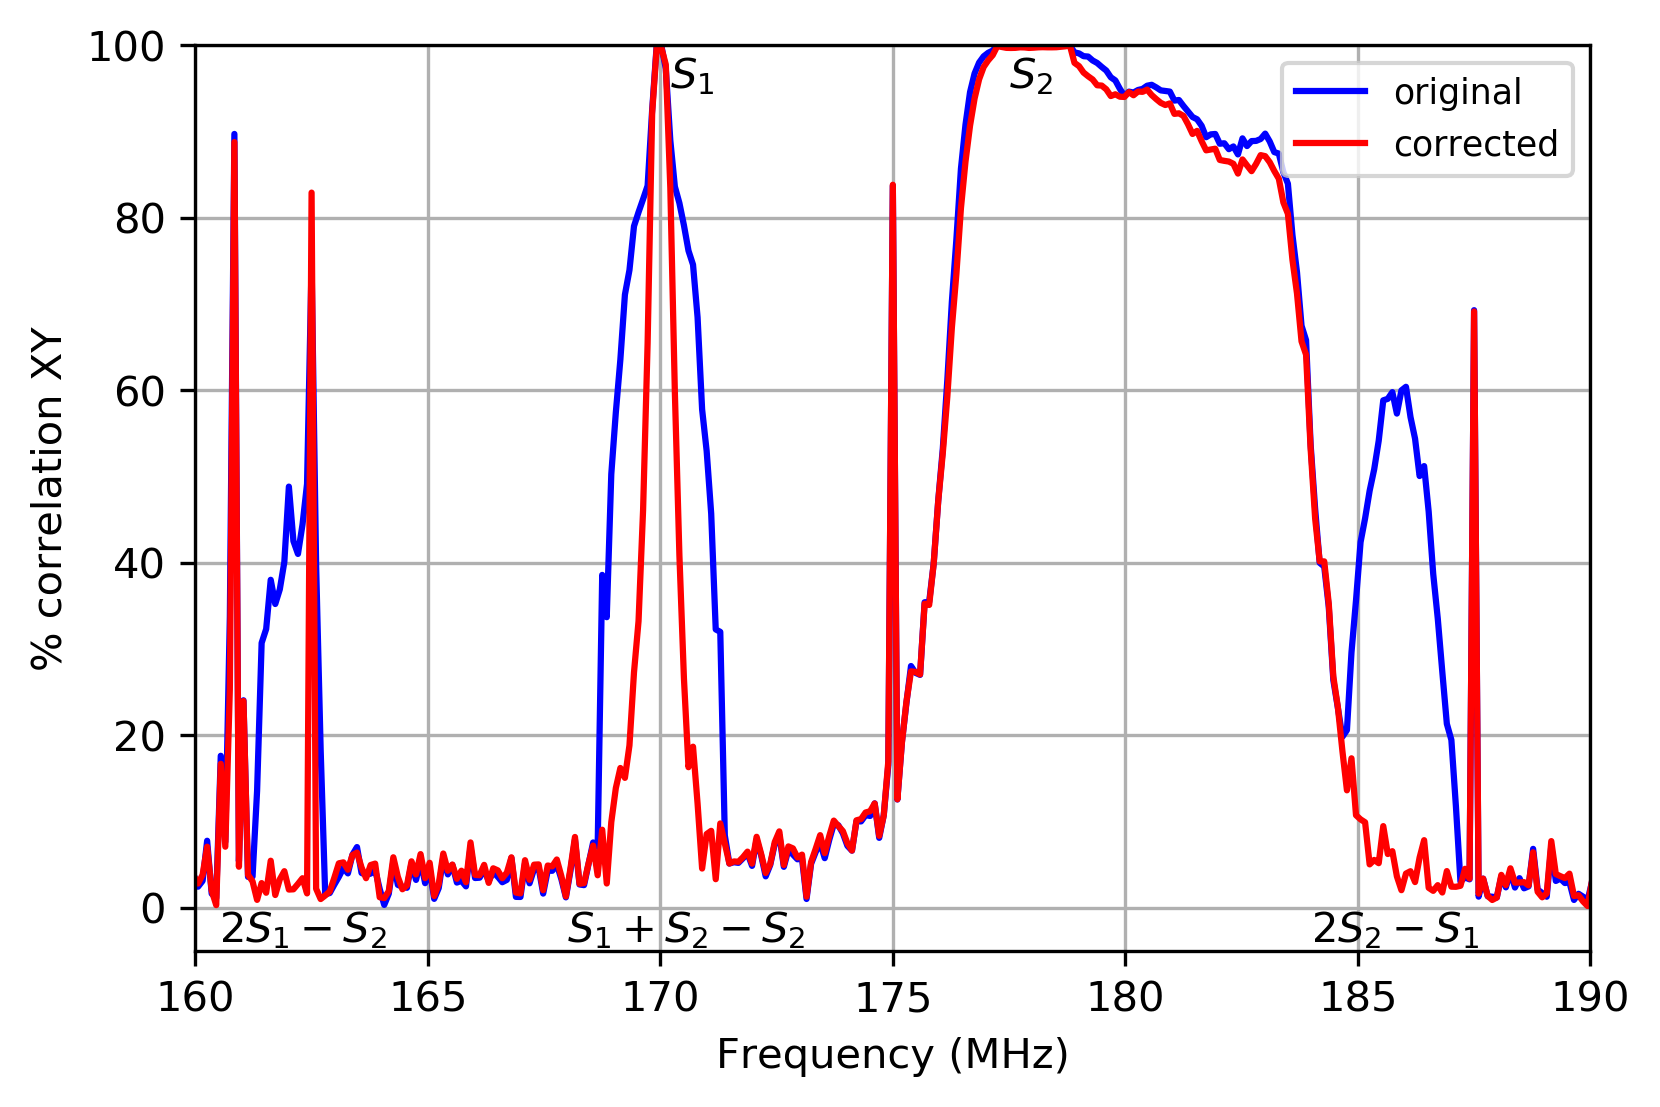

In [7]:
plt.figure(dpi=300)
plt.plot(freq2,100*np.abs(C),'b',label='original')
#plt.plot(freq2,100*np.abs(Cx),'r',label='corrected')
plt.plot(freq2,100*np.abs(Cy),'r',label='corrected')
plt.xlabel("Frequency (MHz)")
plt.ylabel("% correlation XY")
plt.text(170.2,95,'$S_1$')
plt.text(177.5,95,'$S_2$')
plt.text(160.5,-4,'$2S_1-S_2$')
plt.text(168.0,-4,'$S_1+S_2-S_2$')
#plt.text(176.5,90,'$2S_2-S_2$')
plt.text(184.0,-4,'$2S_2-S_1$')
plt.legend(fontsize='small',loc='upper right')
#plt.xlim(600,900)
plt.xlim(160,190)
plt.ylim(-5,100)
#plt.xlim(0,400)
#plt.ylim(-60,-25)
plt.grid()
plt.savefig("XYcorrelation2.png")